<h1>Mid-Term - Part 1</h1>
Compare the two algorithms we studied, K-NN and RLS with linear models, in terms of accuracy and training time


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import time
np.random.seed(100)

def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

<h2>KNN</h2>

In [14]:
def euclidDistance(P1, P2):
    return np.linalg.norm(P1-P2, 2)

#########################
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1, idx2] = euclidDistance(X1[idx1,:], X2[idx2,:])
    return D

##################################
def kNNClassify(Xtr, Ytr, q, Xte):
    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if q > n_train:
        print("q is greater than the number of points, setting q=n_train")
        q = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        idx_dist = dist[idx]
        order_idx_dist = np.argsort(idx_dist)
        q_idx_dist = order_idx_dist[:q]
        Ypred[idx] = np.mean(Ytr[q_idx_dist])

    return Ypred

#####################################################
def QFoldCVkNN(Xtr, Ytr, num_folds, hyperparam_list):
    rnd_state = np.random.RandomState()
    hyperparam_list = np.array(hyperparam_list)
    num_q = len(hyperparam_list)

    n_tot = Xtr.shape[0]

    tr_errors = np.zeros((num_q, num_folds))
    val_errors = np.zeros((num_q, num_folds))

    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)

    for fold_idx in range(num_folds):
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]

        for q_idx, current_q in enumerate(hyperparam_list):
            tr_errors[q_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_q, x_train), y_train)
            val_errors[q_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_q, x_val), y_val)

    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    best_q = hyperparam_list[np.argmin(val_err_mean)]
    best_q_idx = np.atleast_1d(hyperparam_list == best_q).nonzero()

    return best_q, best_q_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

<h2>RLS</h2>

In [15]:
def regularizedLSTrain(Xtr, Ytr, lam):
    n = Xtr.shape[0]
    A = Xtr.transpose() @ Xtr + lam*n*np.eye(Xtr.shape[1])
    b = Xtr.transpose() @ Ytr

    lower_triangular = np.linalg.cholesky(A)

    y = scipy.linalg.solve_triangular(lower_triangular, b, lower=True)
    w = scipy.linalg.solve_triangular(lower_triangular.T, y, lower=False)

    return w

##############################
def regularizedLSTest(w, Xte):
    Ypred = Xte @ w
    return Ypred

##########################################
def QFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]

    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for fold in range(KF):
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        
        for idx, regpar in enumerate(regpar_list):
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            X = Xtr[val_mask==False]
            Y = Ytr[val_mask==False]
            X_val = Xtr[val_mask==True]
            Y_val = Ytr[val_mask==True]

            currW = regularizedLSTrain(X, Y, regpar)

            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)

    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

<h2>Data loading</h2>

In [16]:
def load_dataset(name):
    X, y = [], []
    with open("{}".format(name), 'r') as f:
        for line in f.readlines():
            splitted = line.split(",")
            X.append(splitted[:-1])
            y.append(splitted[-1])
    X, y = np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)
    return X, y

<h2>Dataset 1</h2>

- $D = 10$
- $n = 400$
- Noise $= 10\%$

In [17]:
folds = 5

Xtr, Ytr = load_dataset("./Training/dataset_2_train")
print(f"Shape of X: {Xtr.shape}")
print(f"Shape of Y: {Ytr.shape}")

Shape of X: (400, 10)
Shape of Y: (400,)


<h3>With K-NN</h3>

The best q chosen with the training-set is 1 with training error 0.00%
The best q chosen with 5 folds is 7 with error 27.13 +- 6.20%


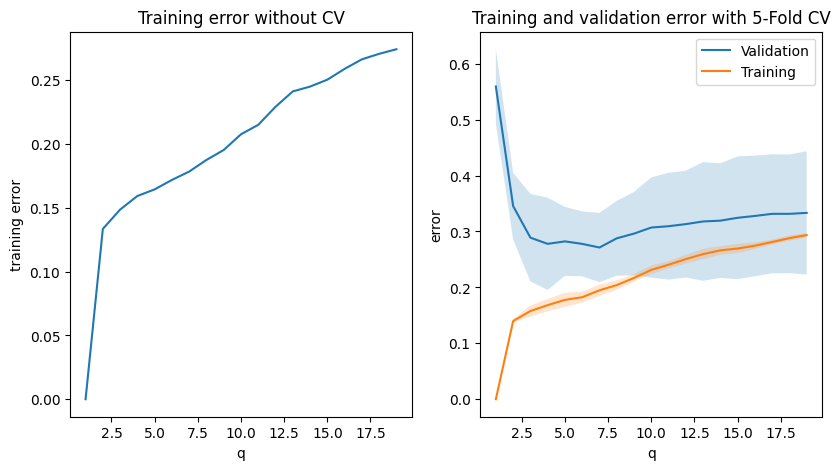

In [ ]:
#Without CV
q_list = range(1, 20)
q_tr_errors = []

start_time = time.time()
for current_q in q_list:
    Ypred = kNNClassify(Xtr, Ytr, current_q, Xtr)
    current_tr_err = calcError(Ypred, Ytr)
    q_tr_errors.append(current_tr_err)
    
best_q = q_list[np.argmin(q_tr_errors)]
time_no_cv = time.time() - start_time

print(f"The best q chosen with the training-set is {best_q} "
      f"with training error {np.min(q_tr_errors)*100:.2f}%")

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(q_list, q_tr_errors)
plt.xlabel("q")
plt.ylabel("training error")
plt.title("Training error without CV")

#With CV
start_time = time.time()
best_q_cv, best_q_idx_cv, tr_err_mean, tr_err_std, val_err_mean, val_err_std = QFoldCVkNN(Xtr, Ytr, folds, q_list)
time_cv = time.time() - start_time

print(f"The best q chosen with {folds} folds is {best_q_cv} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

plt.subplot(132)
plt.plot(q_list, val_err_mean, label="Validation")
plt.fill_between(q_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
plt.plot(q_list, tr_err_mean, label="Training")
plt.fill_between(q_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)
plt.title(f"Training and validation error with {folds}-Fold CV")
plt.ylabel("error")
plt.xlabel("q")
plt.legend();

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

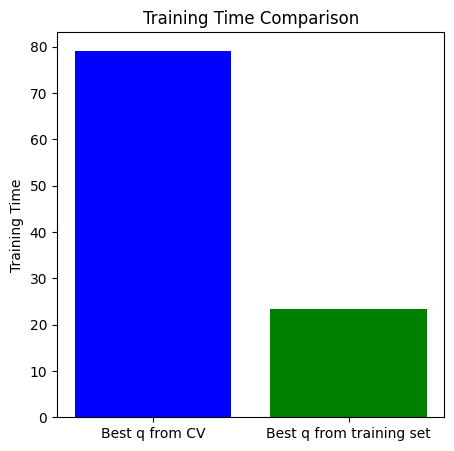

In [20]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>With RLS</h3>

Best lambda found with CV: 0.0026560877829466868


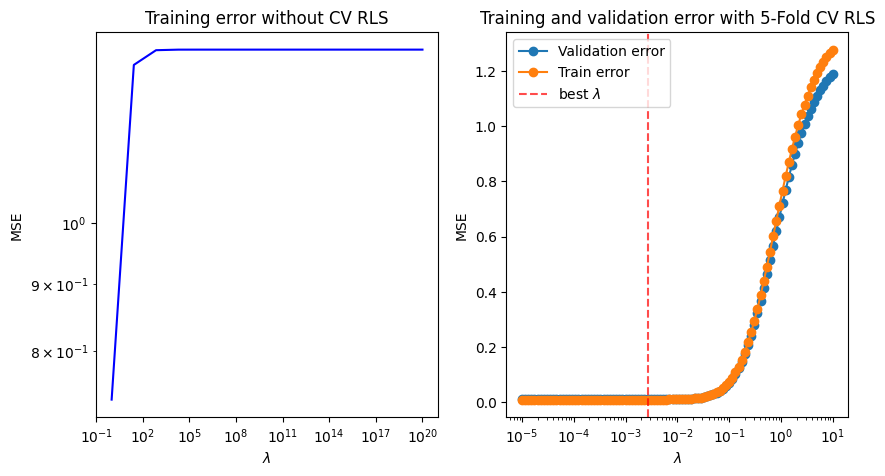

In [21]:
lam_list = np.logspace(0, 20, 15)
tr_err = []

#Without CV
start_time = time.time()
for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)

    Ytr_pred = regularizedLSTest(w, Xtr)

    current_tr_err = calcError(Ytr_pred, Ytr)
    tr_err.append(current_tr_err)

time_no_cv = time.time() - start_time

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Training error without CV RLS")
plt.plot(lam_list, tr_err, '-', c="blue")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.xscale("log")
plt.yscale("log")

#With CV
reg_pars = np.logspace(-5, 1, 100)

start_time = time.time()
bestlam, Vm, Vs, Tm, Ts = QFoldCVRLS(Xtr, Ytr, folds, reg_pars)
time_cv = time.time() - start_time

print("Best lambda found with CV: {}".format(bestlam))

plt.subplot(132)
plt.plot(reg_pars, Vm, '-o', label="Validation error")
plt.plot(reg_pars, Tm, '-o', label="Train error")
plt.title(f"Training and validation error with {folds}-Fold CV RLS")
plt.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label=r"best $\lambda$")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.legend(loc="best")

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

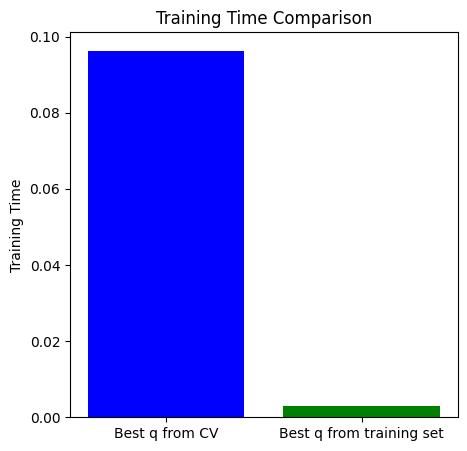

In [22]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>Instructions to load the test set and to evaluate the model</h3>

In [ ]:
Xte, Yte = load_dataset("...")

#KNN without CV
test_error = calcError(kNNClassify(Xtr, Ytr, best_q, Xte), Yte)
print(f'The test error with q={best_q} is {test_error * 100:.2f}%')

#KNN with CV
test_error_cv = calcError(kNNClassify(Xtr, Ytr, best_q_cv, Xte), Yte)
print(f'The test error with q={best_q_cv} and {folds}-Fold CV is {test_error_cv * 100:.2f}%')

#RLS without CV
te_err = []

for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)
    
    Yte_pred = regularizedLSTest(w, Xte)

    current_te_err = calcError(Yte_pred, Yte)
    te_err.append(current_te_err)

print("The test error with RLS is {}".format(te_err))

#RLS with CV
print("Best lambda found with {folds}-Fold CV RLS: {}".format(bestlam))

w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("The test error with RLS CV is {}".format(test_err))

<h2>Dataset 2</h2>

- $D = 10$
- $n = 4000$
- Noise $= 10\%$

In [23]:
Xtr, Ytr = load_dataset("./Training/dataset_3_train")
print(f"Shape of X: {Xtr.shape}")
print(f"Shape of Y: {Ytr.shape}")

Shape of X: (800, 10)
Shape of Y: (800,)


<h3>With K-NN</h3>

The best q chosen with the training-set is 1 with training error 0.00%
The best q chosen with 5 folds is 10 with error 22.11 +- 3.49%


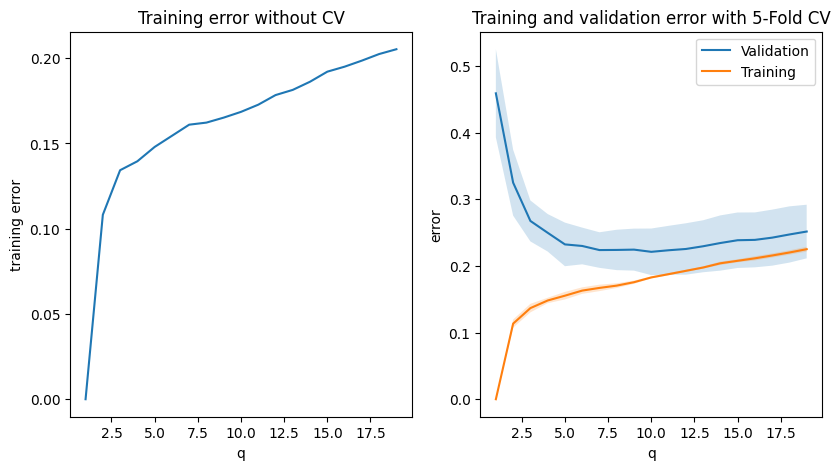

In [24]:
#Without CV
q_list = range(1, 20)
q_tr_errors = []

start_time = time.time()
for current_q in q_list:
    Ypred = kNNClassify(Xtr, Ytr, current_q, Xtr)
    current_tr_err = calcError(Ypred, Ytr)
    q_tr_errors.append(current_tr_err)
    
best_q = q_list[np.argmin(q_tr_errors)]
time_no_cv = time.time() - start_time

print(f"The best q chosen with the training-set is {best_q} "
      f"with training error {np.min(q_tr_errors)*100:.2f}%")

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(q_list, q_tr_errors)
plt.xlabel("q")
plt.ylabel("training error")
plt.title("Training error without CV")

#With CV
start_time = time.time()
best_q_cv, best_q_idx_cv, tr_err_mean, tr_err_std, val_err_mean, val_err_std = QFoldCVkNN(Xtr, Ytr, folds, q_list)
time_cv = time.time() - start_time

print(f"The best q chosen with {folds} folds is {best_q_cv} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

plt.subplot(132)
plt.plot(q_list, val_err_mean, label="Validation")
plt.fill_between(q_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
plt.plot(q_list, tr_err_mean, label="Training")
plt.fill_between(q_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)
plt.title(f"Training and validation error with {folds}-Fold CV")
plt.ylabel("error")
plt.xlabel("q")
plt.legend();

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

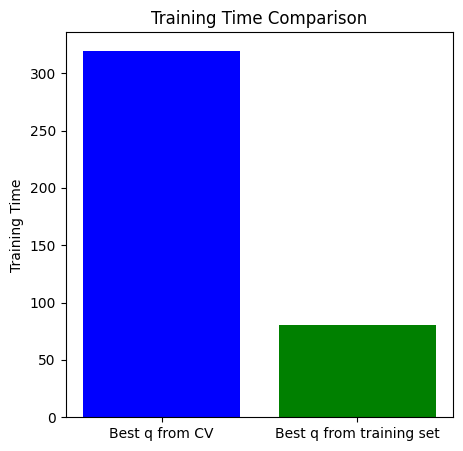

In [25]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>With RLS</h3>

Best lambda found with CV: 1e-05


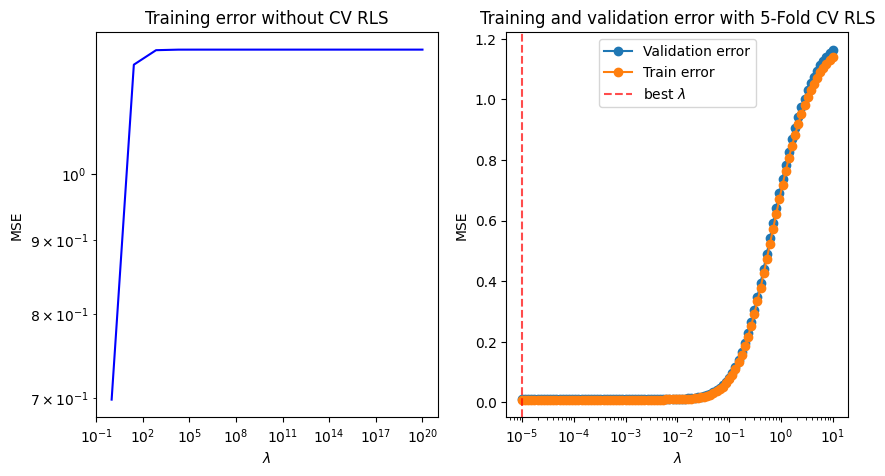

In [26]:
lam_list = np.logspace(0, 20, 15)
tr_err = []

#Without CV
start_time = time.time()
for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)

    Ytr_pred = regularizedLSTest(w, Xtr)

    current_tr_err = calcError(Ytr_pred, Ytr)
    tr_err.append(current_tr_err)

time_no_cv = time.time() - start_time

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Training error without CV RLS")
plt.plot(lam_list, tr_err, '-', c="blue")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.xscale("log")
plt.yscale("log")

#With CV
reg_pars = np.logspace(-5, 1, 100)

start_time = time.time()
bestlam, Vm, Vs, Tm, Ts = QFoldCVRLS(Xtr, Ytr, folds, reg_pars)
time_cv = time.time() - start_time

print("Best lambda found with CV: {}".format(bestlam))

plt.subplot(132)
plt.plot(reg_pars, Vm, '-o', label="Validation error")
plt.plot(reg_pars, Tm, '-o', label="Train error")
plt.title(f"Training and validation error with {folds}-Fold CV RLS")
plt.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label=r"best $\lambda$")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.legend(loc="best")

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

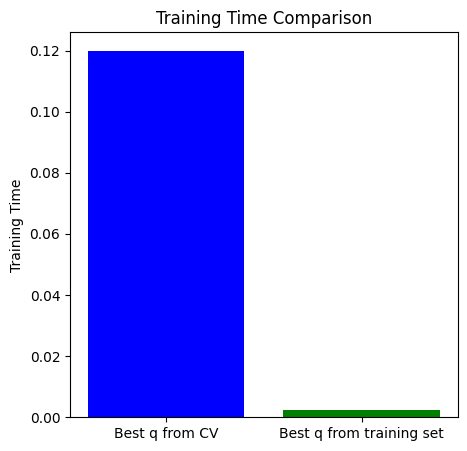

In [27]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>Instructions to load the test set and to evaluate the model</h3>

In [ ]:
Xte, Yte = load_dataset("...")

#KNN without CV
test_error = calcError(kNNClassify(Xtr, Ytr, best_q, Xte), Yte)
print(f'The test error with q={best_q} is {test_error * 100:.2f}%')

#KNN with CV
test_error_cv = calcError(kNNClassify(Xtr, Ytr, best_q_cv, Xte), Yte)
print(f'The test error with q={best_q_cv} and {folds}-Fold CV is {test_error_cv * 100:.2f}%')

#RLS without CV
te_err = []

for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)
    
    Yte_pred = regularizedLSTest(w, Xte)

    current_te_err = calcError(Yte_pred, Yte)
    te_err.append(current_te_err)

print("The test error with RLS is {}".format(te_err))

#RLS with CV
print("Best lambda found with {folds}-Fold CV RLS: {}".format(bestlam))

w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("The test error with RLS CV is {}".format(test_err))

<h2>Dataset 3</h2>

- $D = 4000$
- $n = 400$
- Noise $= 10\%$

In [28]:
Xtr, Ytr = load_dataset("./Training/dataset_5_train")
print(f"Shape of X: {Xtr.shape}")
print(f"Shape of Y: {Ytr.shape}")

Shape of X: (400, 5000)
Shape of Y: (400,)


<h3>With K-NN</h3>

The best q chosen with the training-set is 1 with training error 0.00%
The best q chosen with 5 folds is 10 with error 55214.96 +- 5672.16%


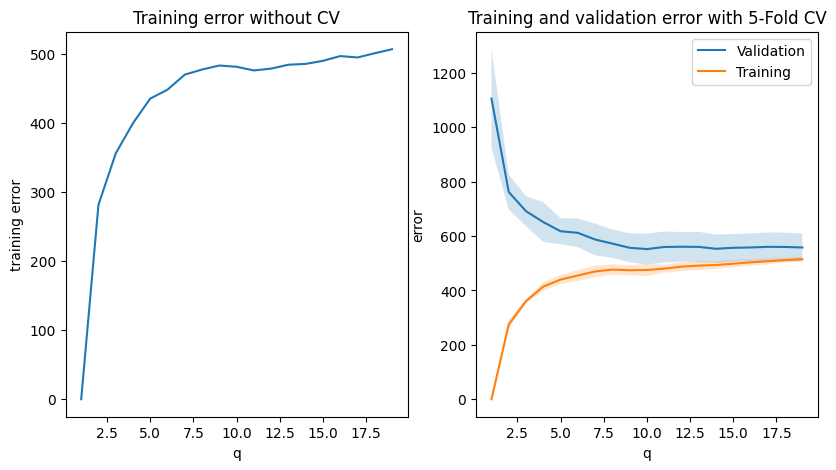

In [29]:
#Without CV
q_list = range(1, 20)
q_tr_errors = []

start_time = time.time()
for current_q in q_list:
    Ypred = kNNClassify(Xtr, Ytr, current_q, Xtr)
    current_tr_err = calcError(Ypred, Ytr)
    q_tr_errors.append(current_tr_err)
    
best_q = q_list[np.argmin(q_tr_errors)]
time_no_cv = time.time() - start_time

print(f"The best q chosen with the training-set is {best_q} "
      f"with training error {np.min(q_tr_errors)*100:.2f}%")

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(q_list, q_tr_errors)
plt.xlabel("q")
plt.ylabel("training error")
plt.title("Training error without CV")

#With CV
start_time = time.time()
best_q_cv, best_q_idx_cv, tr_err_mean, tr_err_std, val_err_mean, val_err_std = QFoldCVkNN(Xtr, Ytr, folds, q_list)
time_cv = time.time() - start_time

print(f"The best q chosen with {folds} folds is {best_q_cv} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

plt.subplot(132)
plt.plot(q_list, val_err_mean, label="Validation")
plt.fill_between(q_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
plt.plot(q_list, tr_err_mean, label="Training")
plt.fill_between(q_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)
plt.title(f"Training and validation error with {folds}-Fold CV")
plt.ylabel("error")
plt.xlabel("q")
plt.legend();

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

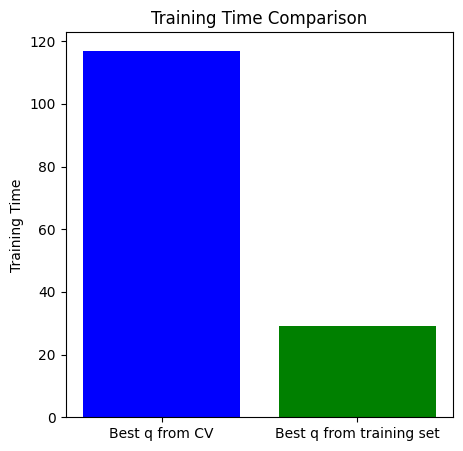

In [30]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>With RLS</h3>

Best lambda found with CV: 0.0008697490026177834


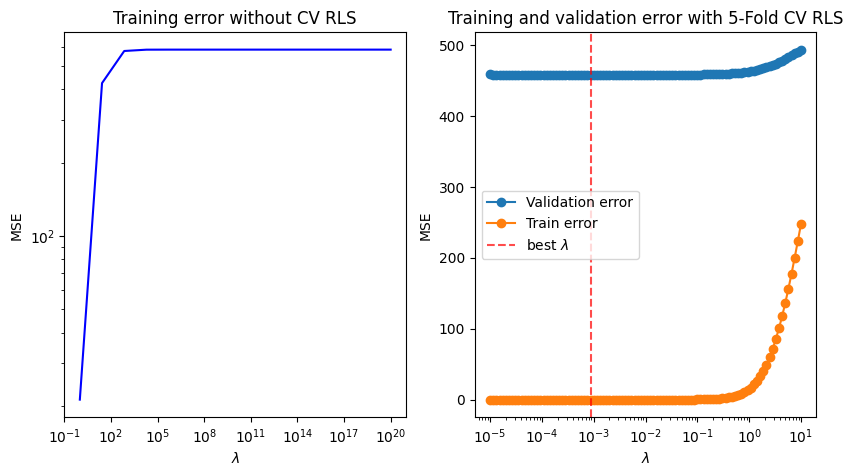

In [31]:
lam_list = np.logspace(0, 20, 15)
tr_err = []

#Without CV
start_time = time.time()
for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)

    Ytr_pred = regularizedLSTest(w, Xtr)

    current_tr_err = calcError(Ytr_pred, Ytr)
    tr_err.append(current_tr_err)

time_no_cv = time.time() - start_time

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Training error without CV RLS")
plt.plot(lam_list, tr_err, '-', c="blue")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.xscale("log")
plt.yscale("log")

#With CV
reg_pars = np.logspace(-5, 1, 100)

start_time = time.time()
bestlam, Vm, Vs, Tm, Ts = QFoldCVRLS(Xtr, Ytr, folds, reg_pars)
time_cv = time.time() - start_time

print("Best lambda found with CV: {}".format(bestlam))

plt.subplot(132)
plt.plot(reg_pars, Vm, '-o', label="Validation error")
plt.plot(reg_pars, Tm, '-o', label="Train error")
plt.title(f"Training and validation error with {folds}-Fold CV RLS")
plt.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label=r"best $\lambda$")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.legend(loc="best")

Comparison of the time

Text(0.5, 1.0, 'Training Time Comparison')

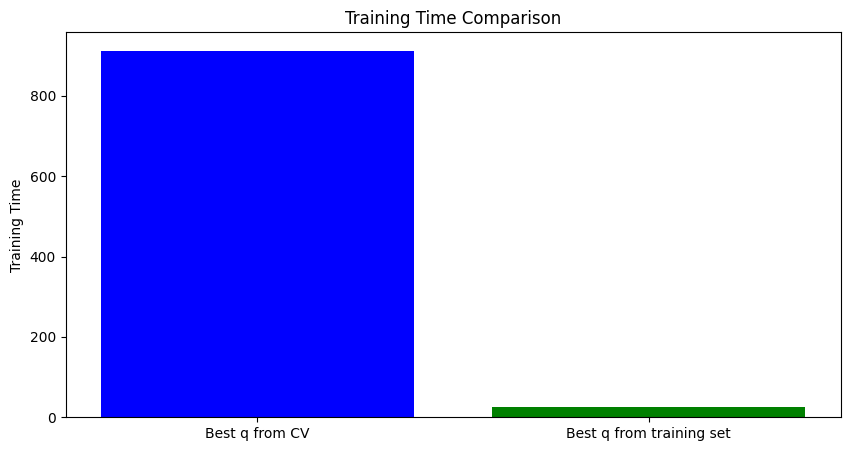

In [ ]:
plt.figure(figsize=(5, 5))
plt.bar(['Best q from CV', 'Best q from training set'], [time_cv, time_no_cv], color=['blue', 'green'])
plt.ylabel("Training Time")
plt.title("Training Time Comparison")

<h3>Instructions to load the test set and to evaluate the model</h3>

In [ ]:
Xte, Yte = load_dataset("...")

#KNN without CV
test_error = calcError(kNNClassify(Xtr, Ytr, best_q, Xte), Yte)
print(f'The test error with q={best_q} is {test_error * 100:.2f}%')

#KNN with CV
test_error_cv = calcError(kNNClassify(Xtr, Ytr, best_q_cv, Xte), Yte)
print(f'The test error with q={best_q_cv} and {folds}-Fold CV is {test_error_cv * 100:.2f}%')

#RLS without CV
te_err = []

for lam in lam_list:
    w = regularizedLSTrain(Xtr, Ytr, lam)
    
    Yte_pred = regularizedLSTest(w, Xte)

    current_te_err = calcError(Yte_pred, Yte)
    te_err.append(current_te_err)

print("The test error with RLS is {}".format(te_err))

#RLS with CV
print("Best lambda found with {folds}-Fold CV RLS: {}".format(bestlam))

w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("The test error with RLS CV is {}".format(test_err))

<h2>Comparison between the two algorithms</h2>

...